### Import libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix, f1_score, classification_report, precision_recall_curve
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier
from lightgbm import LGBMClassifier

### Read dataset

In [2]:
df = pd.read_csv('data/train_set.csv')

### Train-Test split

In [3]:
train = df.iloc[:2600, :]
valid = df.iloc[2600:, :]

X_train = train.drop('payment_delay', axis=1)
y_train = train['payment_delay']

X_valid = valid.drop('payment_delay', axis=1)
y_valid = valid['payment_delay']

### Define the lazy classifier

In [4]:
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=f1_score)
models, predictions = clf.fit(X_train, X_valid, y_train, y_valid)
models.sort_values('f1_score', ascending=False, inplace=True)
models

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:05<00:00,  5.07it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,f1_score,Time Taken
Model,,,,,,
LGBMClassifier,0.97,0.89,0.89,0.97,0.88,0.12
XGBClassifier,0.97,0.91,0.91,0.97,0.87,0.51
RandomForestClassifier,0.97,0.89,0.89,0.97,0.86,1.09
BaggingClassifier,0.96,0.86,0.86,0.96,0.82,0.39
DecisionTreeClassifier,0.93,0.84,0.84,0.93,0.74,0.05
GaussianNB,0.91,0.79,0.79,0.91,0.65,0.02
ExtraTreesClassifier,0.93,0.72,0.72,0.91,0.62,0.40
QuadraticDiscriminantAnalysis,0.89,0.74,0.74,0.88,0.56,0.02
SVC,0.91,0.68,0.68,0.89,0.52,0.20


Looks like LGBM has the best performance. We will proceed with this model further in order to calculate the confusion matrix and the related metrics.

### Fit LGBM model

In [5]:
model = LGBMClassifier(random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

LGBMClassifier(class_weight='balanced', random_state=42)

### Perform  predictions

In [6]:
y_proba = model.predict_proba(X_valid)
precisions, recalls, thresholds = precision_recall_curve(y_valid, y_proba[:, 1])

In [7]:
threshold_90_recall = thresholds[np.argmax(recalls <= 0.85)]
print("Thresholds for 90% recall: ", threshold_90_recall)

y_pred = (y_proba[:, 1] >= threshold_90_recall).astype(int)
report = classification_report(y_valid, y_pred, zero_division=1)

Thresholds for 90% recall:  0.48781393194654016


### Generate confusion matrix

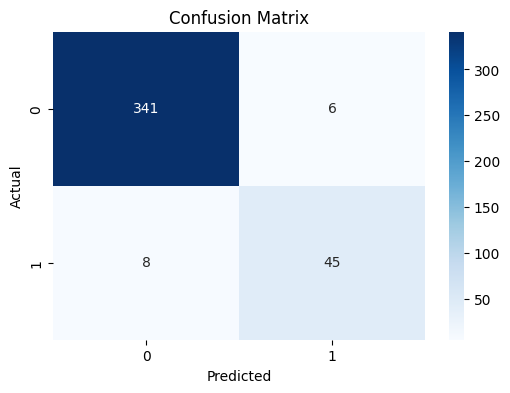

In [8]:
cf_matrix = confusion_matrix(y_valid, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cf_matrix, cmap='Blues', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Generate classification report

In [9]:
report = classification_report(y_valid, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       347
           1       0.88      0.85      0.87        53

    accuracy                           0.96       400
   macro avg       0.93      0.92      0.92       400
weighted avg       0.96      0.96      0.96       400

